# 다산콜 센터 문의내역 자동화 분류모델
* #### single project in DSS-3 (김경수)
![Image](./Resource/dasan_Image.png)
___

## Why?
* 많은 사이트에는 FAQ라는 게시판이 있는데 자주묻는질문들은 항상 같은 답변을 하기 때문에 ‘이것을 자동화할수 없을까’ 라는 의문에서 대량의 데이터를 생각하게 되었고, 다산콜센터 문의내역을 가지고 프로젝트를 진행하게 되었다.

## Goal
* 다산콜센터의 질문들을 머신러닝 기반으로 학습하여 카테고리에 맞게 분류하고 답변을 하는 것을 목표로 한다.
* 다산콜센터에 문의된 질문 **(input)** = > **f(x)** = > 질문의 분류 & 답변 **(output)**

## How?
* 데이터 수집
    + 네이버 지식인에 다산콜센터에서 답변한 게시물을 크롤링 15,995답변 (Samples)
    + 질문에 대한 7가지 카데고리 (y)
    + 2012 ~ 2016년 까지의 질문 (X)
    ___
* 방법론
    * Classification : Multinomial NB, LogisticRegression, SVM 
       + 데이터의 분포를 확인하기 위해서 명사추출과 품사태깅을 적용 (konlpy) 
       + Text Preprocessing 을 위해서 CountVectorizer(), TfidfVectorizer() 수행
       + 여러가지의 모델을 통해서 튜닝을 하면서 accuracy가 높은 모델을 선택 ( TfidfVectorizer, SVM ) 
      ___
    * features = 2012~2106 question 중에서 target class 만을 추출
         + 2012 : ***899개***
         + 2013 : ***1508개***
         + 2014 : ***2437개***
         + 2015 : ***1593개***
         + 2016 : ***1330개***
         + Total : ***= 7767개***
         
    * target =  directorys 
         + ***가족관계 증명민원*** 
         + ***교통민원***
         + ***부동산, 건축 민원***
         + ***서울특별시***
         + ***여권, 비자민원***
         + ***의료보건제도***
         + ***주민등록증 발급***
      ___   
    
* 분석 방법
    * Multinomial NB, LogisticRegression, SVM 

## < Workflow >
### Data => Data distribution  => Data preprocessing  => Modeling  => Optimization  => Accuracy / Word2Vec

### 1. Data

In [1]:
#-*- coding: utf-8 -*-

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from konlpy.utils import pprint
from konlpy.tag import Twitter
import nltk
import matplotlib as mpl
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
from sklearn.preprocessing import LabelEncoder
from konlpy.utils import pprint

call = pd.read_csv('./Resource/data.csv') # 데이터 읽기

In [2]:
call.tail() # 데이터 확인

,질문,디렉토리
6730,주민등록등본뒷자리,주민등록증 발급
6731,주민등록등본 타지역에서 발급되나요??,주민등록증 발급
6732,98년 12월13일생인데 이번년도 12월31일에...,주민등록증 발급
6733,민증을 1월31일까지 만들라고 통지서에 적...,주민등록증 발급
6734,주민등록증 재발급,주민등록증 발급


In [3]:
y = call['디렉토리'] # target
X = call['질문']    # feature

In [4]:
print X.tail()

6730                        주민등록등본뒷자리
6731             주민등록등본 타지역에서 발급되나요??
6732    98년 12월13일생인데 이번년도 12월31일에...
6733       민증을 1월31일까지 만들라고 통지서에 적...
6734                        주민등록증 재발급
Name: 질문, dtype: object


In [5]:
print y.tail()

6730    주민등록증 발급
6731    주민등록증 발급
6732    주민등록증 발급
6733    주민등록증 발급
6734    주민등록증 발급
Name: 디렉토리, dtype: object


### 2. Data distribution

In [6]:
twitter = Twitter()

Nouns = [] # 명사추출
Pos = []   # 품사태깅
for x in X:
    z = x.decode("utf-8")
    Nouns.append(twitter.nouns(z))
    Pos.append(twitter.pos(z))

In [7]:
pprint (Nouns[0:3])

[[가족, 관계, 증명서],
 [차,
  상위,
  계층,
  증명,
  궁금],
 [주민등록, 등본, 질문]]


In [8]:
pprint (Pos[0:3]) 

[[(가족, Noun),
  (관계, Noun),
  (증명서, Noun)],
 [(차, Noun),
  (상위, Noun),
  (계층, Noun),
  (증명, Noun),
  (을, Josa),
  (어떻, Adjective),
  (게, Eomi),
  (하는, Verb),
  (지, Eomi),
  (궁금, Noun),
  (..., Punctuation)],
 [(주민등록, Noun),
  (등본, Noun),
  (질문, Noun),
  ((, Punctuation),
  (급함, Adjective),
  (), Punctuation)]]


In [9]:
# 명사 corpus
corpus = []
for i in range(len(Nouns)):
    corpus += Nouns[i]

In [10]:
# corpus 길이
len(corpus)

24972

In [11]:
# stop_word
def get_stop_words():
    result = set()
    for line in open('./Resource/stopwords-kr.txt','r').readlines():
        result.add(line.strip())
    return result

# tokenize
def tokenize_pos(doc):
    return ['/'.join(t) for t in pos_tagger.pos(doc, norm=True, stem=True)]

pos_tagger = Twitter()

In [12]:
# CountVectorizer
vect = CountVectorizer(stop_words=get_stop_words())
vect.fit(corpus)

print len(vect.vocabulary_)
pprint (vect.vocabulary_)

2053
{가게: 0,
 가격: 1,
 가계: 2,
 가구: 3,
 가기: 4,
 가까이: 5,
 가나: 6,
 가능: 7,
 가도: 8,
 가두: 9,
 가래: 10,
 가맹: 11,
 가면: 12,
 가문: 13,
 가발: 14,
 가방: 15,
 가산: 16,
 가야: 17,
 가요: 18,
 가운데: 19,
 가위: 20,
 가장: 21,
 가정: 22,
 가조: 23,
 가족: 24,
 가족관계등록부: 25,
 가지: 26,
 가터: 27,
 가판: 28,
 가평역: 29,
 각각: 30,
 각종: 31,
 간선: 32,
 간염: 33,
 간이: 34,
 간지: 35,
 감염: 36,
 갑부: 37,
 갑자기: 38,
 강남: 39,
 강남구: 40,
 강능: 41,
 강동: 42,
 강동구: 43,
 강동구청역: 44,
 강변: 45,
 강변역: 46,
 강부: 47,
 강북: 48,
 강북구: 49,
 강서: 50,
 강서구: 51,
 강수영: 52,
 강아지: 53,
 강일: 54,
 강일동: 55,
 개념: 56,
 개명: 57,
 개봉동: 58,
 개설: 59,
 개수: 60,
 개월: 61,
 개인: 62,
 개입: 63,
 개장: 64,
 개화역: 65,
 갱신: 66,
 거래: 67,
 거리: 68,
 거소: 69,
 거여: 70,
 거의: 71,
 거주: 72,
 거주지: 73,
 건가: 74,
 건강: 75,
 건강검진: 76,
 건대: 77,
 건물: 78,
 건설: 79,
 건소: 80,
 건축물: 81,
 걷기: 82,
 검강: 83,
 검사: 84,
 검정고시: 85,
 검진: 86,
 것좀: 87,
 겨울: 88,
 겨울방학: 89,
 격리: 90,
 결과: 91,
 결연: 92,
 결재: 93,
 결정: 94,
 결제: 95,
 결함: 96,
 결핵: 97,
 결혼: 98,
 경과: 99,
 경기: 100,
 경기도: 101,
 경기장: 102,
 경력: 103,
 경복궁: 104,
 경부: 105,
 경우: 106,
 경

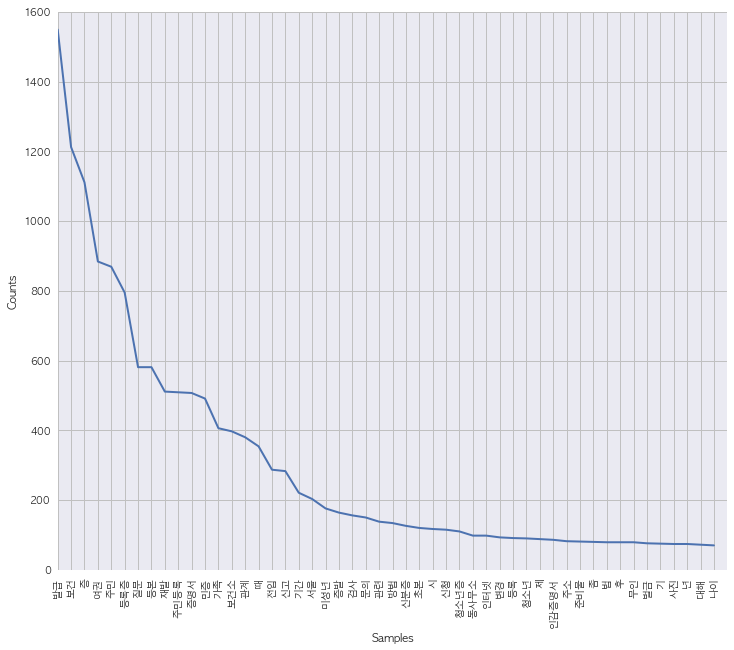

In [13]:
# corpus data 분포

# Mac OS X : /Library/Fonts/AppleGothic.ttf (Mac OS 기준)
# Linux : /usr/share/fonts/nanumfont/NanumGothic.ttf
# Window : /windows/fonts/gulim.ttc

text = nltk.Text(corpus)
font_fname = '/Library/Fonts/AppleGothic.ttf'     
font_name = font_manager.FontProperties(fname=font_fname).get_name()
rc('font', family=font_name)
plt.figure(figsize=(12,10))
text.plot(50)
plt.show()

### 3. Data preprocessing

In [14]:
# LabelEncoder
le = LabelEncoder()
le.fit(y)
z = le.classes_

In [15]:
# 0:가족관계 증명민원
# 1:교통민원
# 2:부동산, 건축민원
# 3:서울특별시
# 4:여권, 비자 민원
# 5:의료보건제도
# 6:주민등록증 발급

y = le.transform(y)
y

array([0, 0, 0, ..., 6, 6, 6])

In [16]:
# train_test_split (9 : 1)
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=5387, test_size=1347)
len(X_train), len(X_test)

(5387, 1347)

In [17]:
X_train.head()

171         인터넷에서 등,초본 출력의 방법
4880               보건증발급이요...
2462    중학생이 주민등록등본 동사무서에서...
3368                    보건증발급
3515               민증언제나오죠 ㅠㅠ
Name: 질문, dtype: object

In [18]:
y_train

array([0, 5, 0, ..., 3, 0, 6])

### 4. Modeling

#### CountVectorizer(), MultinomialNB()

In [19]:
# CountVectorizer, MultinomialNB 
clf_1 = Pipeline([('vect', CountVectorizer())])
features = clf_1.fit_transform(X_train)

#cross_val_score
cross_val_score(MultinomialNB(),features, y_train)

array([ 0.73622705,  0.75459098,  0.74233129])

In [20]:
# make_pipeline
clf_1 = Pipeline([('vect', CountVectorizer()),
               ('clf', MultinomialNB())])

clf_1.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [21]:
# model의 vocabulary
pprint (list(clf_1.named_steps['vect'].vocabulary_)[:10])

[남부터미널에서,
 만5세,
 여권분실시,
 가족관계를,
 전문연구요원,
 보건증말이에요,
 언제나올까요,
 주소를,
 대학교,
 무과세]


In [22]:
# classification_report
print classification_report(y_test, clf_1.predict(X_test))

             precision    recall  f1-score   support

          0       0.82      0.61      0.70       203
          1       1.00      0.09      0.16        23
          2       0.93      0.58      0.71        69
          3       0.98      0.37      0.53       123
          4       0.89      0.70      0.78       168
          5       0.85      0.84      0.85       301
          6       0.62      0.92      0.74       460

avg / total       0.79      0.74      0.73      1347



In [23]:
# Accuracy
print accuracy_score(y_test, clf_1.predict(X_test))

0.743875278396


#### TfidfVectorizer, MultinomialNB()

In [24]:
# TfidfVectorizer, MultinomialNB()
clf_2 = Pipeline([('vect',TfidfVectorizer())])
features = clf_2.fit_transform(X_train)

# cross_val_score
cross_val_score(MultinomialNB(),features, y_train)

array([ 0.65275459,  0.66722315,  0.66313441])

In [25]:
# make_pipeline
clf_2 = Pipeline([('vect',TfidfVectorizer()),
                  ('clf',MultinomialNB())])

clf_2.fit(X_train, y_train)

Pipeline(steps=[('vect', TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm=u'l2', preprocessor=None, smooth_idf=True...rue,
        vocabulary=None)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [26]:
pprint (list(clf_2.named_steps['vect'].vocabulary_)[:10])

[남부터미널에서,
 만5세,
 여권분실시,
 가족관계를,
 전문연구요원,
 보건증말이에요,
 언제나올까요,
 주소를,
 대학교,
 무과세]


In [27]:
# classification_report
print classification_report(y_test, clf_2.predict(X_test))

             precision    recall  f1-score   support

          0       0.84      0.53      0.65       203
          1       0.00      0.00      0.00        23
          2       1.00      0.25      0.40        69
          3       1.00      0.25      0.40       123
          4       0.95      0.63      0.76       168
          5       0.82      0.79      0.80       301
          6       0.56      0.93      0.70       460

avg / total       0.76      0.69      0.67      1347



/usr/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [28]:
# accuracy_score
print accuracy_score(y_test, clf_2.predict(X_test))

0.690423162584


### 5. Optimization

#### CountVectorizer(tokenizer, stop_words) / MultinomialNB(alpha=0.5) ,LogisticRegression(), SVC(kernel='linear')

In [29]:
# CountVectorizer(tokenizer, stop_words), MultinomialNB(alpha=0.5)
clf_3 = Pipeline([
            ('vect', CountVectorizer(tokenizer=tokenize_pos, stop_words=get_stop_words())), 
            ('clf', MultinomialNB(alpha=0.5))])
clf_3.fit(X_train, y_train)

# CountVectorizer(tokenizer, stop_words), LogisticRegression()
clf_4 = Pipeline([('vect', CountVectorizer(tokenizer=tokenize_pos, stop_words=get_stop_words())),
               ('clf', LogisticRegression())])
clf_4.fit(X_train, y_train)

# CountVectorizer(tokenizer, stop_words), SVC(kernel='linear')
clf_5 = Pipeline([('vect', CountVectorizer(tokenizer=tokenize_pos, stop_words=get_stop_words())),
               ('clf', SVC(kernel='linear'))])
clf_5.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None,
        stop_words=set(['\x...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

#### TfidfVectorizer(tokenizer, stop_words) / MultinomialNB(alpha=0.5) ,LogisticRegression(), SVC(kernel='linear')¶

In [30]:
# TfidfVectorizer(tokenizer, stop_words), MultinomialNB(alpha=0.5)
clf_6 = Pipeline([
            ('vect', TfidfVectorizer(tokenizer=tokenize_pos, stop_words=get_stop_words())), 
            ('clf', MultinomialNB(alpha=0.5))])
clf_6.fit(X_train, y_train)

# TfidfVectorizer(tokenizer, stop_words), LogisticRegression()
clf_7 = Pipeline([('vect', TfidfVectorizer(tokenizer=tokenize_pos, stop_words=get_stop_words())),
               ('clf', LogisticRegression())])
clf_7.fit(X_train, y_train)

# TfidfVectorizer(tokenizer, stop_words), SVC(kernel='linear')
clf_8 = Pipeline([('vect', TfidfVectorizer(tokenizer=tokenize_pos, stop_words=get_stop_words())),
               ('clf', SVC(kernel='linear'))])
clf_8.fit(X_train, y_train)

Pipeline(steps=[('vect', TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm=u'l2', preprocessor=None, smooth_idf=True...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [31]:
# classification_report
print "clf_3 Model","-"*60
print classification_report(y_test, clf_3.predict(X_test), digits=4)
print "clf_4 Model","-"*60
print classification_report(y_test, clf_4.predict(X_test), digits=4)
print "clf_5 Model","-"*60
print classification_report(y_test, clf_5.predict(X_test), digits=4)
print "clf_6 Model","-"*60
print classification_report(y_test, clf_6.predict(X_test), digits=4)
print "clf_7 Model","-"*60
print classification_report(y_test, clf_7.predict(X_test), digits=4)
print "clf_8 Model","-"*60
print classification_report(y_test, clf_8.predict(X_test), digits=4)

clf_3 Model ------------------------------------------------------------
             precision    recall  f1-score   support

          0     0.7570    0.7980    0.7770       203
          1     0.8667    0.5652    0.6842        23
          2     0.8684    0.9565    0.9103        69
          3     0.9327    0.7886    0.8546       123
          4     0.9205    0.9643    0.9419       168
          5     0.9387    0.9668    0.9525       301
          6     0.8717    0.8565    0.8640       460

avg / total     0.8808    0.8797    0.8788      1347

clf_4 Model ------------------------------------------------------------
             precision    recall  f1-score   support

          0     0.8416    0.8374    0.8395       203
          1     0.8235    0.6087    0.7000        23
          2     0.8571    0.9565    0.9041        69
          3     0.8824    0.8537    0.8678       123
          4     0.9697    0.9524    0.9610       168
          5     0.9453    0.9767    0.9608       301
  

### 6. Accuracy

In [32]:
print "clf_3 : ", accuracy_score(y_test, clf_3.predict(X_test))
print "clf_4 : ", accuracy_score(y_test, clf_4.predict(X_test))
print "clf_5 : ", accuracy_score(y_test, clf_5.predict(X_test))
print "clf_6 : ", accuracy_score(y_test, clf_6.predict(X_test))
print "clf_7 : ", accuracy_score(y_test, clf_7.predict(X_test))
print "clf_8 : ", accuracy_score(y_test, clf_8.predict(X_test))

clf_3 :  0.879732739421
clf_4 :  0.904231625835
clf_5 :  0.898292501856
clf_6 :  0.844097995546
clf_7 :  0.896807720861
clf_8 :  0.90571640683


### Word2Vec

In [34]:
word = pd.read_csv('./Resource/word2Vec.csv') # 데이터 읽기

In [35]:
y = call['디렉토리'] # target
X = call['질문']    # feature

In [36]:
Nouns = [] # 명사추출

for x in X:
    z = x.decode("utf-8")
    Nouns.append(twitter.nouns(z))

In [37]:
# 명사 corpus
corpus = []
for i in range(len(Nouns)):
    corpus += Nouns[i]

In [38]:
train_docs = [row for row in corpus]
sentences = [tokenize_pos(d) for d in train_docs]

In [39]:
pprint (sentences)

[[가족/Noun],
 [관계/Noun],
 [증명서/Noun],
 [차/Noun],
 [상위/Noun],
 [계층/Noun],
 [증명/Noun],
 [궁금/Noun],
 [주민등록/Noun],
 [등본/Noun],
 [질문/Noun],
 [가족/Noun],
 [관계/Noun],
 [증명서/Noun],
 [주민등록/Noun],
 [등본/Noun],
 [비용/Noun],
 [초본/Noun],
 [발급/Noun],
 [질문/Noun],
 [인감/Noun],
 [나이/Noun],
 [만/Noun],
 [살입/Noun],
 [제적/Noun],
 [등본/Noun],
 [원본/Noun],
 [열람/Noun],
 [신청/Noun],
 [가족/Noun],
 [증명/Noun],
 [발급/Noun],
 [저가/Noun],
 [본인/Noun],
 [인감증명서/Noun],
 [대리인/Noun],
 [발급/Noun],
 [등본/Noun],
 [대해/Noun],
 [가족/Noun],
 [관계/Noun],
 [증명서/Noun],
 [제적/Noun],
 [등본/Noun],
 [질문/Noun],
 [가족/Noun],
 [증명/Noun],
 [발급/Noun],
 [법/Noun],
 [정/Noun],
 [전입/Noun],
 [신고/Noun],
 [가능/Noun],
 [여부/Noun],
 [일반도/Noun],
 [인감도장/Noun],
 [주민등록/Noun],
 [등본/Noun],
 [가족/Noun],
 [관계/Noun],
 [증명서/Noun],
 [법/Noun],
 [줄다/Verb],
 [저/Noun],
 [제/Noun],
 [엄마/Noun],
 [쪽/Noun],
 [등본/Noun],
 [땔수잇/Noun, 나/Josa],
 [주민등록/Noun],
 [등/Noun],
 [초본/Noun],
 [발급/Noun],
 [시/Noun],
 [출생/Noun],
 [증명/Noun],
 [분실/Noun],
 [가족/Noun],
 [관계/Noun],
 [증명서/Noun],
 [등본/Noun],
 [동거인/Nou

In [40]:
from gensim.models import word2vec
model = word2vec.Word2Vec(sentences)
model.init_sims(replace=True)

/usr/local/lib/python2.7/site-packages/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


In [41]:
model.similarity(*tokenize_pos(u'가족 증명'))

0.13212303855449728

In [42]:
model.similarity(*tokenize_pos(u'발급 본인'))

0.027177782470165918

In [43]:
pprint(model.most_similar(positive=tokenize_pos(u'발급 증명'), negative=tokenize_pos(u'주민등록'), topn=1))

[(신고/Noun, 0.3305814266204834)]


In [44]:
pprint (model.most_similar(tokenize_pos(u'미성년'), topn=10))

[(임산부/Noun, 0.31412220001220703),
 (일제/Noun, 0.2745574712753296),
 (주민등록/Noun, 0.2189093828201294),
 (고등학생/Noun, 0.21222233772277832),
 (환승/Noun, 0.2110823094844818),
 (성병/Noun, 0.20770186185836792),
 (필요/Noun, 0.20600542426109314),
 (이용/Noun, 0.20419175922870636),
 (무인/Noun, 0.20343142747879028),
 (영업/Noun, 0.1999349296092987)]
